# Fit Model Parameters to Data #
### Nitika Yadlapalli ###
Use existing all sky maps published on LAMBDA (https://lambda.gsfc.nasa.gov/) to find model parameters that best fit the data

Currently, MCMC models based on example shown here: https://emcee.readthedocs.io/en/v2.2.1/user/line/

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import emcee
import scipy.optimize as op
from scipy import stats
import corner

In [2]:
# relevant constants

c = 3e10
k = 1.381e-16
pc = 3.086e18
d = 8e3*pc # distance from galactic center to sun ~8kpc

Jy = 1e-23 # erg s^-1 cm^-2 Hz^-1

In [250]:
# function describing line of sight through disk and halo models, based on sky coordinates, 
# geometry of disk/halo
# l and b given in degrees (as from hp.pix2ang) - convert to radians
# d = distance of sun from center of galaxy

def LineOfSightDisk(l, b, d, R_disk, h_disk):
    
    l = np.array(l)
    b = np.array(b)
    # first calculate length of line of sight through disk
    
    l = np.deg2rad(l)
    b = np.deg2rad(b)

    l = np.array([np.min([l_, (2*np.pi)-l_]) for l_ in l])
    b = np.abs(b)
    B_disk =  -l - np.arcsin((d/R_disk)*np.sin(l)) + np.pi
    r_disk = np.sqrt(-(2*R_disk*d*np.cos(B_disk)) + (R_disk**2) + (d**2))
    
    b_crit = np.arctan(0.5*h_disk/r_disk)
    b_below = np.nan_to_num((b <= b_crit)*r_disk/(np.cos(b)))
    b_above = np.nan_to_num((b > b_crit)*0.5*h_disk/(np.sin(b)))
    
    D_disk = b_below+b_above
    
#     if b <= np.arctan(0.5*h_disk/r_disk):
#         D_disk = r_disk/(np.cos(b))

        
#     else: 
#         D_disk = 0.5*h_disk/(np.sin(b))
        
    return np.array(D_disk)
        

def LineOfSightHalo(l, b, d, R_halo):  
    
    # next calculate length of line of sight through halo
    
    l = np.deg2rad(np.array(l))
    b = np.deg2rad(np.array(b))
    
    l = np.minimum(l, (2*np.pi)-l)
    
    b = np.abs(b)
    b_ = np.pi - b
    
    d_proj = d*np.abs(np.cos(l))
    B_halo1 = np.pi - l - np.arcsin((d/R_halo)*np.sin(l))
    
#     if l > np.pi/2:
#         b = b_
    R_eff_above = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) + d_proj
    B_halo_above = (np.pi - b_ - np.arcsin((d_proj/R_eff_above)*np.sin(b)))
    D_tot_above = (l >= np.pi/2)*(np.sqrt((R_eff_above**2) + (d_proj**2) - (2*R_eff_above*d_proj*np.cos(B_halo_above))))
        
#     else: 
    R_eff_below = np.sqrt((R_halo**2) + (d**2) - (2*R_halo*d*np.cos(B_halo1))) - d_proj
    B_halo_below = (np.pi - b - np.arcsin((d_proj/R_eff_below)*np.sin(b)))
    D_tot_below = (l < np.pi/2)*(np.sqrt((R_eff_below**2) + (d_proj**2) - (2*R_eff_below*d_proj*np.cos(B_halo_below))))
    
    
    D_halo = D_tot_above + D_tot_below
    
#     if D_halo < 0:
#         D_halo = 0
    
    return D_halo

## 1.4 GHz Map with Disk and Extragalactic Only Model ##
Sky map used: https://lambda.gsfc.nasa.gov/product/foreground/fg_stockert_villa_info.cfm

Assume only disk (no halo), and use uniform extragalactic sky brightness as calculated in sky-brightness-model notebook

In [4]:
## Set up known parameters ##

NSIDE_sky = 256

NSIDE_dg = 32
NPIX_dg = hp.nside2npix(NSIDE_dg)

m = np.arange(NPIX_dg)
coords = hp.pix2ang(NSIDE_dg, m, lonlat=True)
l = coords[0]
b = coords[1]

nu = 1420e6
T_eg = 0.08866 # K
T_rms = (50/3)*1e-3 # K
T_CMB = 2.725 # K

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


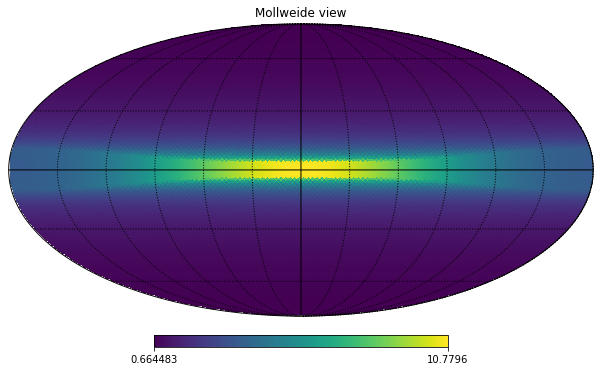

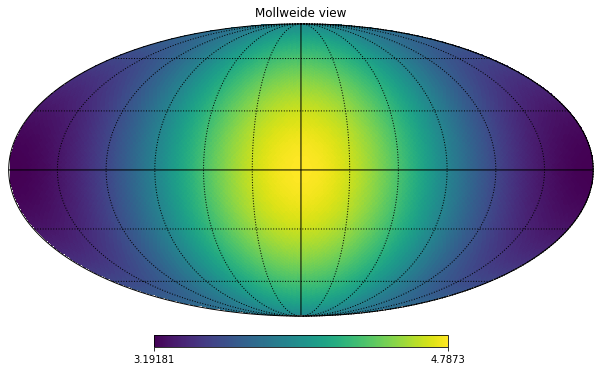

In [252]:
# test  models

test_disk = LineOfSightDisk(l, b, d, 2*d, 0.37*d)*9e-41*(c**2)/(2*k*(nu**2))
hp.mollview(test_disk)
hp.graticule()

test_halo = LineOfSightHalo(l, b, d, 5*d)*2e-41*(c**2)/(2*k*(nu**2))
hp.mollview(test_halo)
hp.graticule()

NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


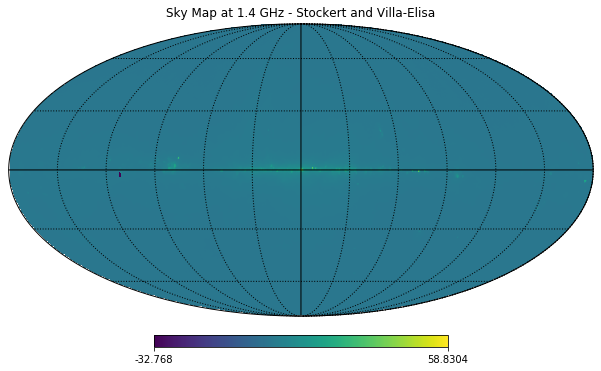

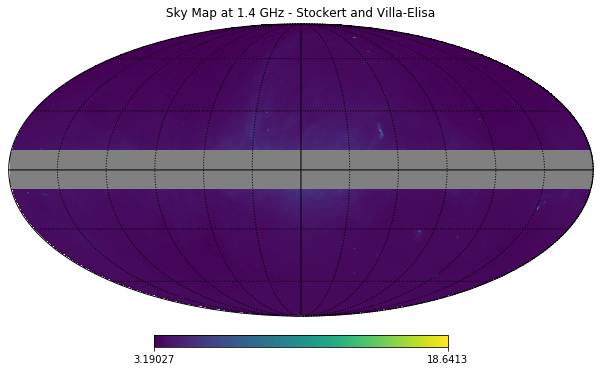

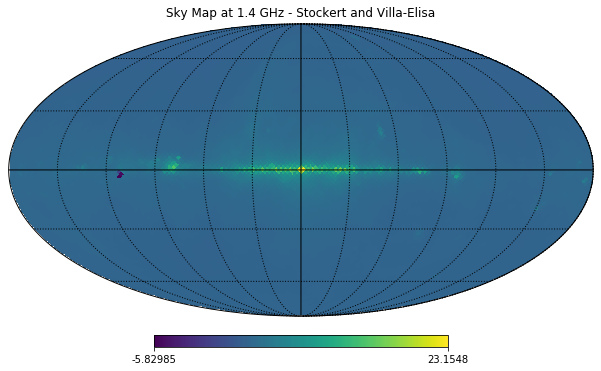

In [254]:
## show 1.4 GHz sky map ##

map_1420 = hp.read_map('STOCKERT+VILLA-ELISA_1420MHz_1_256.fits')
map_1420_mod = hp.read_map('STOCKERT+VILLA-ELISA_1420MHz_1_256.fits')
map_1420_dg = hp.pixelfunc.ud_grade(map_1420, 32)

#Mask all pixels between -10 < b < +10 by setting them all to zero
idx = hp.query_strip(NSIDE_sky, np.deg2rad(90-10), np.deg2rad(90+10))
map_1420_mod[idx] = None
#map_1420_dg[idx] = None

hp.mollview(map_1420/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

hp.mollview(map_1420_mod/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

hp.mollview(map_1420_dg/1000, title = "Sky Map at 1.4 GHz - Stockert and Villa-Elisa")
hp.graticule()

84
0.17203743755817413
0.0
Measured T_rms =  97.95313652900668 mK
Reported T_rms =  16.67 mK


/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


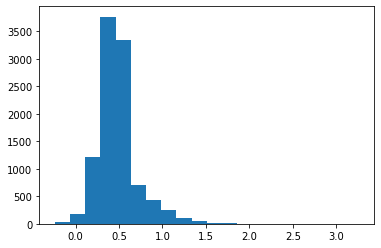

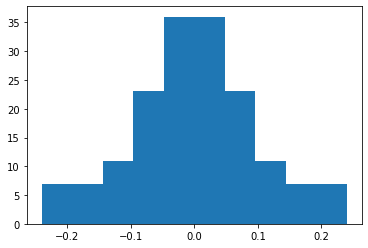

In [191]:

idx_exb = hp.query_strip(NSIDE_dg, np.deg2rad(90-10), np.deg2rad(90+10))
disk = [10**24.78, 10**21.92, 10**(-40.61)]

R_disk = disk[0]
h_disk = disk[1]
j_disk = disk[2]

# residuals = T_res = T_sky - T_eg - T_disk - T_CMB
T_notdisk = map_1420_dg/1000 - T_eg - T_CMB
residuals = T_notdisk - LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2))
residuals[idx_exb] = None
plt.hist(residuals, 20)

neg_res_idx = np.argwhere(residuals<=0)
neg_res = residuals[neg_res_idx]
#print(neg_res)
print(len(neg_res))

if len(neg_res) == 0:
    
    print("No negative residuals")
    
else:

    neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))

    #print(stats.anderson(neg_res2.T))

    plt.figure()
    plt.hist(neg_res2.T[0], 10)
    print(stats.shapiro(neg_res2.T[0])[1])

    res_cdf = np.cumsum(np.histogram(neg_res2, 10)[0])
    res_cdf = res_cdf/np.max(res_cdf)


    #print(len(neg_res))
    #print(len(residuals))
    #hp.mollview(residuals)

    #plt.figure()
    #plt.plot(res_cdf)
    
    print(np.mean(neg_res2))
    print('Measured T_rms = ', np.std(neg_res2)*1000, 'mK')
    print('Reported T_rms = ', "{0:.2f}".format(50/3), 'mK')

KstestResult(statistic=0.038764234578155254, pvalue=0.4337872056635898)
(0.9954572916030884, 0.15402327477931976)
NormaltestResult(statistic=1.719317753755941, pvalue=0.42330645731181804)


KstestResult(statistic=0.5947423627405897, pvalue=0.8711669640986334)
(0.9881945848464966, 0.17203743755817413)
NormaltestResult(statistic=1.4700136720590506, pvalue=0.4795021810726229)


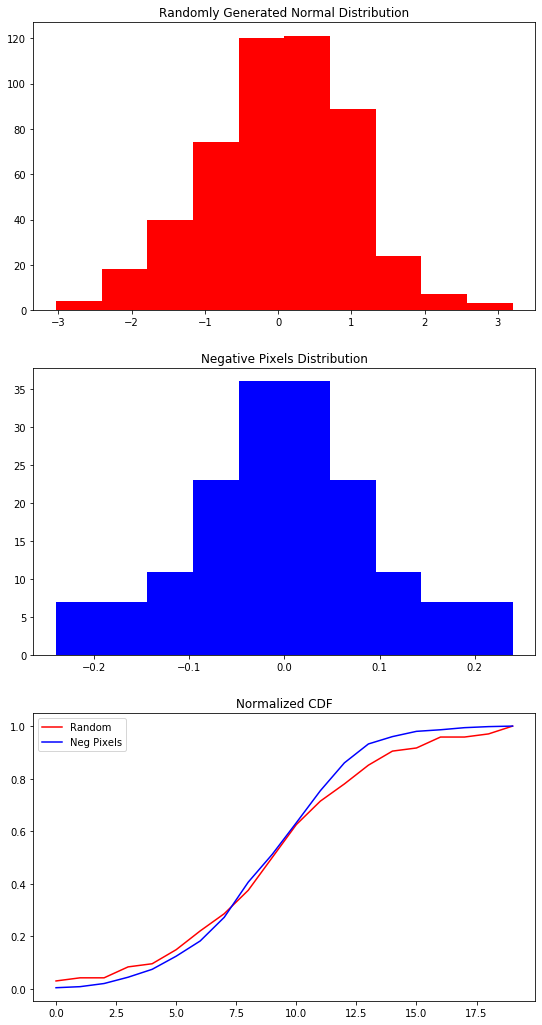

In [175]:
f = stats.norm.rvs(size=500)

plt.figure(figsize=(9,18))
plt.subplot(311)
plt.hist(f, color='r')
plt.title('Randomly Generated Normal Distribution')

print(stats.kstest(f, 'norm'))
print(stats.shapiro(f))
print(stats.normaltest(f))
print('\n')
print(stats.kstest(neg_res2.T, 'norm'))
print(stats.shapiro(neg_res2.T[0]))
print(stats.normaltest(neg_res2.T[0]))

res_cdf2 = np.cumsum(np.histogram(f, 20)[0])
res_cdf2 = res_cdf2/np.max(res_cdf2)

plt.subplot(312)
plt.hist(neg_res2, color='b')
plt.title('Negative Pixels Distribution')

plt.subplot(313)
plt.title('Normalized CDF')
plt.plot(res_cdf, 'r-', label='Random')
plt.plot(res_cdf2, 'b-', label='Neg Pixels')
plt.legend()

plt.savefig('KStest.jpg')

In [160]:
# def log of likelihood function

def lnlike(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
    
    #idx_exb = latitudes of -10 < b < 10 that we wish to exclude
    
    R_disk = disk[0]
    h_disk = disk[1]
    j_disk = disk[2]
    
    # residuals = T_res = T_sky - T_eg - T_disk
    T_notdisk = T_sky/1000 - T_eg - T_CMB
    residuals = T_notdisk - LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2))
    residuals[idx_exb] = None
    
    neg_res_idx = np.argwhere(residuals<=0)
    neg_res = residuals[neg_res_idx]
    
    if len(neg_res)==0:
        return -np.inf
    
    neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))
    L = stats.kstest(neg_res2.T, 'norm')[1]

    lnL = np.log(L)
    return lnL


def lnlike2(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
    
    #idx_exb = latitudes of -10 < b < 10 that we wish to exclude
    
    R_disk = disk[0]
    h_disk = disk[1]
    j_disk = disk[2]
    
    # residuals = T_res = T_sky - T_eg - T_disk
    T_notdisk = T_sky/1000 - T_eg - T_CMB
    residuals = T_notdisk - LineOfSightDisk(l, b, d, R_disk, h_disk)*j_disk*(c**2)/(2*k*(nu**2))
    residuals[idx_exb] = None
    
    neg_res_idx = np.argwhere(residuals<=0)
    neg_res = residuals[neg_res_idx]
    
    if len(neg_res)<3:
        return -np.inf
    
    neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))
    L = stats.shapiro(neg_res2.T[0])[1]

    lnL = np.log(L)
    return lnL


In [161]:
# set up log priors

def lnprior(disk):
    
    R_disk = disk[0]
    h_disk = disk[1]
    j_disk = disk[2]

    if d < R_disk < 1000*d and 0 < h_disk < 5*d and 1e-42 < j_disk < 1e-39:
        return 0.0
    
    return -np.inf


In [162]:
# full log probability 

def lnprob(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
    lp = lnprior(disk)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb)

def lnprob2(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb):
    lp = lnprior(disk)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(disk, nu, l, b, T_sky, T_eg, T_rms, idx_exb)

In [163]:
# Use this cell to test good starting point for walkers

idx_exb = hp.query_strip(NSIDE_dg, np.deg2rad(90-10), np.deg2rad(90+10))

testln = lnlike([2*d, 0.35*d, 2.5e-41], nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb)
print(testln)
print(np.exp(testln))

testln2 = lnlike2([2*d, 0.35*d, 2.5e-41], nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb)
print(testln2)
print(np.exp(testln2))

-0.16882363907553996
0.8446578548911767
-0.6844389412137932
0.5043731331825256


/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal


In [164]:
# initialize walkers

ndim = 3
nwalkers = 200
disk_init = [2*d, 0.35*d, 2.5e-41]

init = [disk_init]
for i in range(nwalkers-1):
    #start walkers such that all values are positive and mean multiplicative factor is 1
    vary = np.abs(np.random.randn(3)+1)
    init.append([disk_init[i]*vary[i] for i in range(3)])

In [117]:
#set up sampler and run MCMC

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb))

sampler.run_mcmc(init, 2000)

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


(array([[2.36604734e+25, 5.01827125e+21, 6.96287658e-41],
        [6.32592129e+24, 5.31958834e+22, 6.55389919e-42],
        [9.75002748e+24, 3.93764545e+20, 6.36493497e-40],
        [5.37275697e+24, 6.89707065e+22, 2.32068724e-42],
        [1.50158073e+25, 6.34448975e+20, 2.86438504e-40],
        [5.67077067e+24, 1.51946996e+21, 1.25092760e-40],
        [2.96329851e+24, 2.49120929e+22, 1.20647647e-41],
        [1.24167675e+25, 4.26159000e+22, 7.78146888e-42],
        [1.97264898e+25, 1.64248021e+21, 2.97233295e-40],
        [1.31334698e+25, 1.09824561e+22, 1.44424254e-41],
        [6.29632312e+24, 8.42558922e+21, 3.93184185e-41],
        [7.20772003e+24, 2.82089165e+21, 7.69730892e-41],
        [1.36078141e+25, 4.48476846e+21, 1.15498321e-40],
        [4.50997288e+24, 1.29810388e+22, 1.50523487e-41],
        [1.33623353e+25, 6.18651915e+21, 5.45310791e-41],
        [1.84369197e+25, 5.63148186e+20, 4.22270654e-40],
        [1.00610569e+25, 3.41387836e+22, 8.92811569e-42],
        [1.731

In [118]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
print(samples.shape)
samples[:,0] = np.log10(samples[:,0])
samples[:,1] = np.log10(samples[:,1])
samples[:,2] = np.log10(samples[:,2])

(390000, 3)


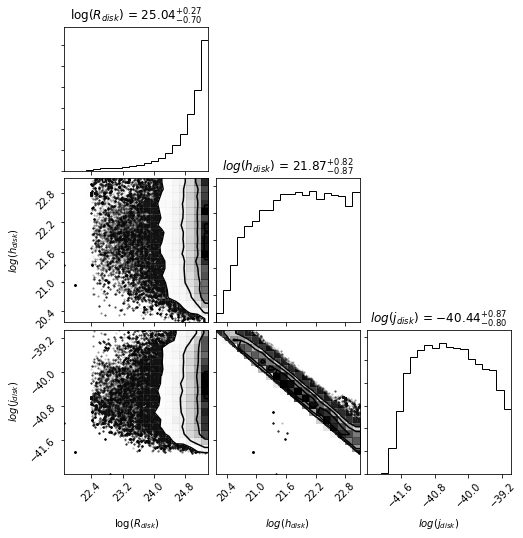

In [228]:
fig = corner.corner(samples, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$"], show_titles=True)
plt.savefig('notes/corner_disk_kstest.jpg')

In [120]:
# look at individual chains

print(50*d)
print(10**np.max(samples[:,0]))

x = sampler.chain
print(x.shape)

#plt.plot(x[:,:,2][25], 'k-')
#plt.imshow

1.2344e+24
2.4686636470778493e+25
(200, 2000, 3)


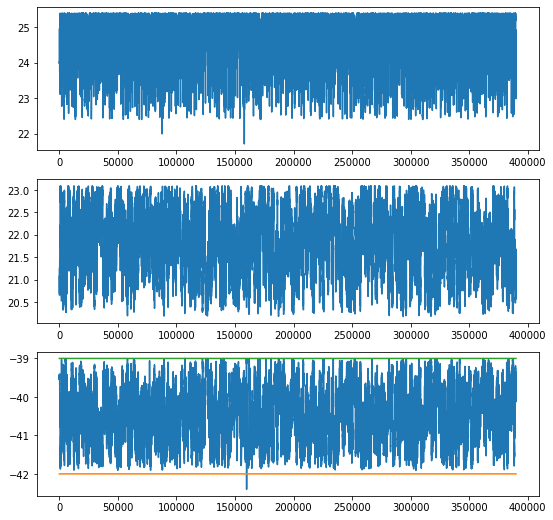

In [121]:
plt.figure(figsize=(9,9))
plt.subplot(311)
plt.plot(samples[:,0],label='R_disk')
plt.subplot(312)
plt.plot(samples[:,1],label='h_disk')
plt.subplot(313)
plt.plot(samples[:,2],label='j_disk')
plt.plot(np.arange(len(samples[:,2])),np.ones(len(samples[:,2]))*-42)
plt.plot(np.arange(len(samples[:,2])),np.ones(len(samples[:,2]))*-39)

In [165]:
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(nu, l, b, map_1420_dg, T_eg, T_rms, idx_exb))

sampler2.run_mcmc(init, 1000)

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less_equal
/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log


(array([[1.45775662e+25, 6.68864178e+20, 3.09352345e-40],
        [2.14248371e+25, 1.35489632e+22, 1.27647642e-41],
        [1.12047614e+24, 2.37013526e+22, 8.06175672e-42],
        [1.03289015e+24, 1.84905705e+21, 1.17194420e-40],
        [1.93492686e+25, 3.43460520e+21, 4.61382590e-41],
        [1.38605095e+25, 6.89000678e+22, 2.89397710e-42],
        [8.30742699e+23, 6.33919563e+22, 2.41237697e-42],
        [1.33056785e+25, 2.34318217e+21, 7.67103931e-41],
        [1.98967325e+25, 1.48464586e+21, 1.22798179e-40],
        [1.07576989e+25, 8.37360247e+21, 2.16672772e-41],
        [1.20353785e+25, 2.26906652e+22, 8.88578006e-42],
        [8.83278679e+24, 1.36491039e+22, 1.24031463e-41],
        [2.15660679e+25, 3.57983720e+22, 6.90883683e-42],
        [4.03602440e+24, 6.19814738e+22, 3.14831037e-42],
        [3.27457664e+22, 2.35033627e+22, 1.51425414e-41],
        [4.20197197e+24, 3.58956112e+21, 4.24848568e-41],
        [5.15386676e+22, 5.14502895e+22, 1.12411711e-41],
        [6.864

In [216]:
samples2 = sampler2.chain[:, 50:, :].reshape((-1, ndim))
print(samples2.shape)
samples2[:,0] = np.log10(samples2[:,0])
samples2[:,1] = np.log10(samples2[:,1])
samples2[:,2] = np.log10(samples2[:,2])

R_disk2, h_disk2, j_disk2 = np.percentile(samples2[:,0], 50), np.percentile(samples2[:,1], 50), np.percentile(samples2[:,2], 50)

(190000, 3)


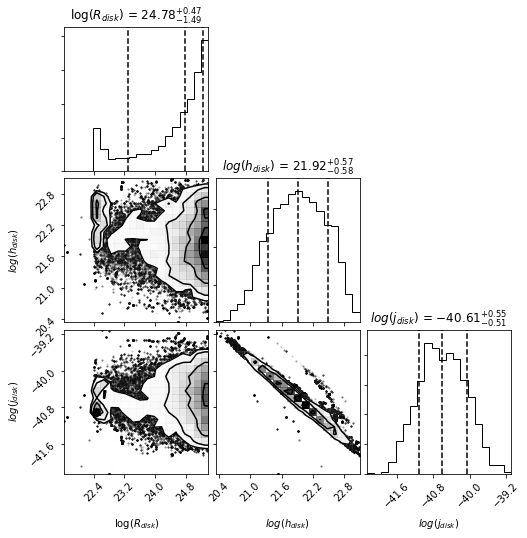

In [229]:
fig2 = corner.corner(samples2, labels=["log($R_{disk})$", "$log(h_{disk})$", "$log(j_{disk})$"], show_titles=True, quantiles=[0.16, 0.5, 0.84])
plt.savefig('notes/corner_disk_shapiro.jpg')

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


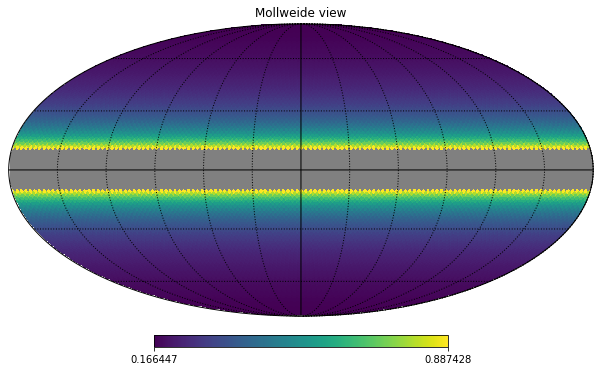

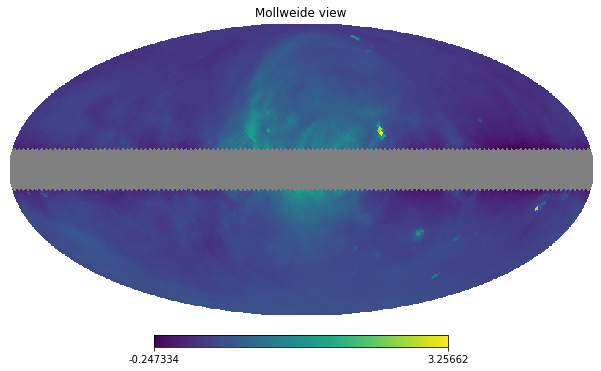

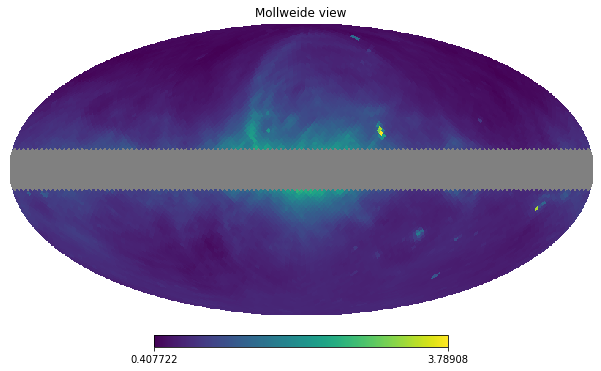

In [230]:
disk_model = LineOfSightDisk(l, b, d, 10**R_disk2, 10**h_disk2)*(10**j_disk2)*(c**2)/(2*k*(nu**2))
disk_model[idx_exb]= None
hp.mollview(disk_model)
hp.graticule()

res = map_1420_dg/1000 - test - T_CMB - T_eg
hp.mollview(res)

map_1420_dg[idx_exb]=None
sky = map_1420_dg/1000 - T_CMB - T_eg
hp.mollview(sky)

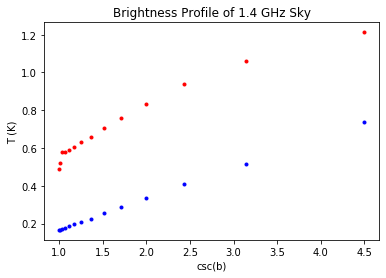

In [248]:
# Construct a T_b vs csc(b) graph

b_range = np.linspace(10,90,15)

cscb = []

Tb_disk = []
Tb_sky = []
Tb_res = []

for i in range(len(b_range)-1):
    
    b1 = 90 - b_range[i]
    b2 = 90 - b_range[i+1]
    
    bmid = 0.5*(b_range[i] + b_range[1+i])
    
    cscb.append(1/(np.sin(np.deg2rad(bmid)))) 
    
    idx = hp.query_strip(NSIDE_dg, np.deg2rad(b2), np.deg2rad(b1))
    Tb_disk.append(np.mean(disk_model[idx]))
    Tb_sky.append(np.mean(sky[idx]))
    Tb_res.append(np.mean(res[idx]))
    
plt.figure(0)
plt.title('Brightness Profile of 1.4 GHz Sky')
plt.ylabel('T (K)')
plt.xlabel('csc(b)')
plt.plot(cscb, Tb_disk, 'b.', label='All-Sky Map')
plt.plot(cscb, Tb_sky, 'r.', label='Disk Model')
plt.savefig('notes/1420_cscb_compare.jpg')

/home/nitikayad96/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


(array([2.180e+02, 4.879e+03, 4.142e+03, 6.910e+02, 1.530e+02, 2.500e+01,
        0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00]),
 array([-0.24733441,  0.10306147,  0.45345735,  0.80385323,  1.15424911,
         1.50464499,  1.85504087,  2.20543675,  2.55583263,  2.90622851,
         3.25662439]),
 <a list of 10 Patch objects>)

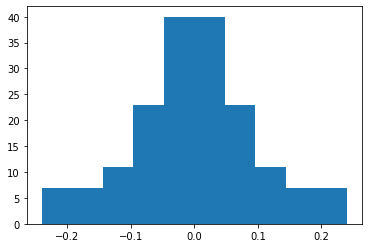

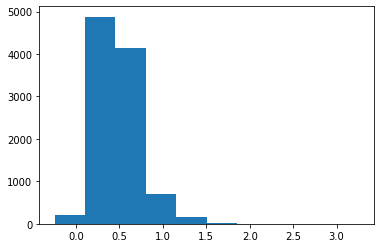

In [249]:
neg_res_idx = np.argwhere(res<=0)
neg_res = residuals[neg_res_idx]
neg_res2 = np.concatenate((neg_res, np.negative(neg_res)))

plt.figure()
plt.hist(neg_res2.T[0], 10)

plt.figure()
plt.hist(res)
